# 패키지 설치

In [5]:
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install konlpy

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-2ptdxges
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-2ptdxges
     |████████████████████████████████| 454.4 MB 8.8 kB/s 
     |████████████████████████████████| 4.0 MB 40.7 MB/s 
     |████████████████████████████████| 1.2 MB 52.9 MB/s 
     |████████████████████████████████| 462 kB 65.4 MB/s 
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2255829 sha256=a16aba02fb1957f361e27d4d32113c1ee4712cf8bb9b60102beb2777b571cf06
  Stored in directory: /tmp/pip-ephem-wheel-cache-lkbmbe8k/wheels/9b/93/81/a2a7dc8c66ede5bf30634d20635f32b95eac7ca2ea8844058b
Successfully built pykospacing
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.39.0
    Uninstalling grpcio-1.39.0:
      Successfully uninstalled grpcio-1.39.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-wdw3izxv
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-wdw3izxv
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=0204d50dcf8e6e053888d6e226755d487de16054da6b7454756de386b444edce
  Stored in directory: /tmp/pip-ephem-wheel-cache-hymyo7lw/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


# 라이브러리 임포트

In [35]:
import pandas as pd
from tqdm.auto import tqdm
import re
import matplotlib.pyplot as plt

#교정 라이브러리
from pykospacing import Spacing #띄어쓰기
from hanspell import spell_checker #맞춤법

# 토크나이져
from konlpy.tag import Okt

# 데이터 확인

In [8]:
# 데이터 경로 PATH 지정
df = pd.read_excel(PATH)

In [9]:
df.head()

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류(우선순위 가장 높은것 선택)
0,1,6438,상담직원과 빠른연결했슴좋겠어요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
1,2,6850,안기다리고. 빨리상담되었음좋겠다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
2,3,7294,너무 오래기다리고 상담이 늦어져요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
3,4,9484,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
4,5,10350,상담받으려면오래기다리는게불편함,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NO                    1000 non-null   int64  
 1   NO2                   1000 non-null   int64  
 2   발화                    1000 non-null   object 
 3   발화1                   1000 non-null   object 
 4   발화1의 우선순위             1000 non-null   int64  
 5   발화2                   32 non-null     object 
 6   발화2의 우선순위             32 non-null     float64
 7   발화3                   3 non-null      object 
 8   발화3의 우선순위             3 non-null      float64
 9   최종분류(우선순위 가장 높은것 선택)  1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.2+ KB


# 데이터 확인을 위해 1차 단순 긍/부정 + 중립 분류

In [11]:
def labeling(df):
    if '불만' in df:
        return 0
    elif '칭찬' in df:
        return 1
    else:
        return '중립'

In [12]:
df['label'] = df['최종분류(우선순위 가장 높은것 선택)'].apply(labeling)

# 중립 제거
df = df[df['label']!='중립']

In [13]:
df.reset_index(inplace=True)
df.head()

,index,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류(우선순위 가장 높은것 선택),label
0,0,1,6438,상담직원과 빠른연결했슴좋겠어요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템,0
1,1,2,6850,안기다리고. 빨리상담되었음좋겠다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템,0
2,2,3,7294,너무 오래기다리고 상담이 늦어져요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템,0
3,3,4,9484,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템,0
4,4,5,10350,상담받으려면오래기다리는게불편함,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템,0


In [14]:
df = df[['발화','최종분류(우선순위 가장 높은것 선택)']]

## 텍스트 전처리

In [15]:
# 한글 영문만 남기고 모두 제거하는 코드
def preprocessing(text):
    # 특수문자나 이모티콘 등 아래의 특수기호들을 제거합니다(%등은 남김).
    text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 위에서 특수문자를 제거한 text에서 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    return text

In [16]:
def clean_text(text):
    text = re.sub('http[s]?://\S+', '', text) # http url 제거
    text = re.sub('\S*@\S*\s?', '', text) # 기자 emails 제거
    text = re.sub(r'\[.*?\]', '', text) # 대괄호안에 텍스트 제거 : 뉴스이름 + 기자이름
    text = re.sub(r'\w*\d\w*', '', text) # 숫자 포함하는 텍스트 제거
    text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)#특수문자 이모티콘 제거
    text = re.sub("\n", '', text) #개행문자 제거
    text = re.sub("\xa0", '', text) #개행문자 제거
    text = re.sub(r'Copyright .* rights reserved', '', text) # "Copyright all rights reserved" 제거
    return text

In [23]:
def correcting (df,col):
  spacing = Spacing()
  
  for i in tqdm(range(len(df))):
      df.loc[i,col] = spacing(df.loc[i,col])

  for i in tqdm(range(len(df))):
      sent = df.loc[i,col]
      spelled_sent = spell_checker.check(sent)
      hanspell_sent = spelled_sent.checked
      df.loc[i,col] = hanspell_sent
  return df.head(5)

In [19]:
df['발화']= df['발화'].apply(lambda x: preprocessing(x))

In [24]:
correcting(df, '발화')

  0%|          | 0/993 [00:00<?, ?it/s]

  0%|          | 0/993 [00:00<?, ?it/s]

,발화,최종분류(우선순위 가장 높은것 선택)
0,상담직원과 빠른 연결했음 좋겠어요,불만>고객서비스>상담시스템
1,안 기다리고 빨리 상담되었으면 좋겠다,불만>고객서비스>상담시스템
2,너무 오래 기다리고 상담이 늦어져요,불만>고객서비스>상담시스템
3,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템
4,상담받으려면 오래 기다리는 게 불편함,불만>고객서비스>상담시스템


In [30]:
okt = Okt()
texts_ko = [okt.morphs(doc) for doc in df.발화]
print(texts_ko[0])

['상담', '직원', '과', '빠른', '연결했음', '좋겠어요']


In [31]:
# 명사추출
text_noun = [okt.nouns(doc) for doc in df.발화]
print(text_noun[0])

['상담', '직원']


In [32]:
df['text_tokenized'] = texts_ko

In [33]:
data_word = df.text_tokenized.tolist()
data_word[:10]

[['상담', '직원', '과', '빠른', '연결했음', '좋겠어요'],
 ['안', '기다리고', '빨리', '상담', '되었으면', '좋겠다'],
 ['너무', '오래', '기다리고', '상담', '이', '늦어져요'],
 ['상담', '직원', '과', '통화', '가', '매우', '힘들다'],
 ['상담', '받으려면', '오래', '기다리는', '게', '불편함'],
 ['상담', '하려면', '많이', '기다려야', '하는', '게', '불편합니다'],
 ['상담', '원', '이', '통화', '중이', '라', '많이', '기다려야', '해', '요'],
 ['상담', '직원', '과의', '연결', '이', '빠르게', '연결', '되면', '촣', '겠습니다'],
 ['ars', '상담', '직원', '너무', '많이', '기다려야', '하는', '불편해요'],
 ['상담', '원', '통화', '가', '너', '믜', '힘듦']]

# 문장 길이와 토큰화 후 최대 단어 수

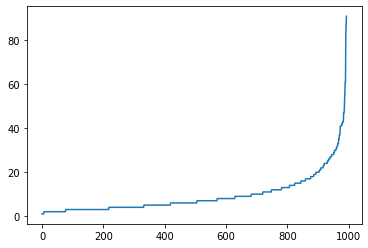

934


In [36]:
sentence_len = [len(sentence) for sentence in data_word]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

# 대부분이 30단어 이하로 구성되어있고 특히 25단어 이하인 문장의 수는 972개로 전체의 97%임
# 따라서 문장길이 기준을 25로 맞추어 이 이상은 생략, 이하는 패딩으로 길이를 맞춤 -> 임베딩 레이어에 넣을 준비 마침

리뷰의 최대 길이 : 91
리뷰의 평균 길이 : 9.387713997985902


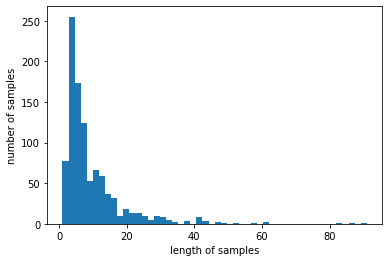

In [39]:
print('리뷰의 최대 길이 :',max(len(l) for l in data_word))
print('리뷰의 평균 길이 :',sum(map(len, data_word))/len(data_word))
plt.hist([len(s) for s in data_word], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()